In [ ]:
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Conv2D, MaxPooling2D, Dense, Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from keras.callbacks import EarlyStopping

# Data preprocessing

In [ ]:
dataset_path = "/kaggle/input/ocular-disease/dataset/dataset"
label = {"ARMD": 0, "cataract": 1, "diabetic_retinopathy": 2, "glaucoma": 3, "normal": 4}
img_size = 224
X = []
y = []
for folder in os.listdir(dataset_path):
    files = os.listdir(dataset_path + '/' + folder)
    for file in files:
        image = cv2.imread(dataset_path + '/' + folder + '/' + file)
        image_array = cv2.resize(image, (img_size, img_size))
        X.append(list(image_array))
        y.append(label[folder])

print(f'There are {len(X)} images in dataset')

There are 4728 images in dataset


In [ ]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print("X_train shape:", X_train.shape)

X_train shape: (3782, 224, 224, 3)


In [ ]:
cat_y_train = keras.utils.to_categorical(y_train, 5)
cat_y_test = keras.utils.to_categorical(y_test, 5)
print("cat_y_train:", cat_y_train.shape)
input_shape = (224, 224, 3)
num_classes = 5

cat_y_train: (3782, 5)


# Meta Heuristic Algorithm for Hyper parameters tuning

In [ ]:
!pip install mealpy
from mealpy import Problem, FloatVar, IntegerVar, MPA, SMA, BBO, FPA


class HyperParameterTuning(Problem):
    def obj_func(self, x):
        solution = self.decode_solution(x)

        model = Sequential()
        model.add(Input(shape=input_shape))
        for i in range(solution["n_Denses"]):
            model.add(Dense(solution["m_nodes_per_Dense"][i]))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(num_classes, activation="softmax"))

        optimizer = tf.keras.optimizers.Adam(learning_rate=solution["learning_rate"])
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        history = model.fit(X_train, cat_y_train, epochs=1, batch_size=32, validation_split=0.1)
        loss = (history.history['loss'])[-1]
        return loss

bounds = [
    IntegerVar(lb=1, ub=5, name='n_Denses'),
    IntegerVar(lb=(16, )*5, ub=(256, )*5, name='m_nodes_per_Dense'),
    FloatVar(lb=0.001, ub=0.1, name="learning_rate")
]

problem = HyperParameterTuning(bounds=bounds, minmax="min")

mpa_model = MPA.OriginalMPA(epoch=1, pop_size=5)
mpa_g_best = mpa_model.solve(problem)
print("MPA fitness:", mpa_g_best.target.fitness)
mpa_solution = problem.decode_solution(mpa_g_best.solution);

sma_model = SMA.OriginalSMA(epoch=1, pop_size=5)
sma_g_best = sma_model.solve(problem)
print("SMA fitness:", sma_g_best.target.fitness)
sma_solution = problem.decode_solution(sma_g_best.solution);

bbo_model = BBO.OriginalBBO(epoch=1, pop_size=5)
bbo_g_best = bbo_model.solve(problem)
print("BBO fitness:", bbo_g_best.target.fitness)
bbo_solution = problem.decode_solution(bbo_g_best.solution);

solutions = {mpa_g_best.target.fitness: mpa_solution, sma_g_best.target.fitness: sma_solution, bbo_g_best.target.fitness: bbo_solution}
best_solution = solutions[math.min(solutions.keys())]

model = Sequential()
model.add(Input(shape=input_shape))
for i in range(best_solution["n_Denses"]):
    model.add(Dense(best_solution["m_nodes_per_Dense"][i]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))
optimizer = tf.keras.optimizers.Adam(learning_rate=best_solution["learning_rate"])

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, cat_y_train, epochs=1, batch_size=32, validation_split=0.1)

107/107 ━━━━━━━━━━━━━━━━━━━━ 596s 6s/step - accuracy: 0.3673 - loss: 2550.4243 - val_accuracy: 0.6201 - val_loss: 71.4886
107/107 ━━━━━━━━━━━━━━━━━━━━ 921s 9s/step - accuracy: 0.3307 - loss: 895.2563 - val_accuracy: 0.6781 - val_loss: 10.6242
107/107 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.3838 - loss: 382.7870 - val_accuracy: 0.6807 - val_loss: 23.5323
107/107 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.3255 - loss: 684.9363 - val_accuracy: 0.5752 - val_loss: 20.3622
107/107 ━━━━━━━━━━━━━━━━━━━━ 974s 9s/step - accuracy: 0.3171 - loss: 3350.0562 - val_accuracy: 0.5778 - val_loss: 28.5786
  3/107 ━━━━━━━━━━━━━━━━━━━━ 47:24 27s/step - accuracy: 0.1580 - loss: 33314.3789

# Meta Heuristic Algorithm for Optimizing NN parameters

In [ ]:
parameters = sum(w.flatten().shape[0] for w in model.get_weights())
print("number of model parameters:", parameters)

def setWeights(X):
    index = 0
    for layer in model.layers[1:]:
        weights_shape = layer.get_weights()[0].shape
        weights_size = layer.get_weights()[0].flatten().shape[0]
        weights = np.reshape(X[index:index + weights_size], weights_shape)
        index += weights_size

        bias_shape = layer.get_weights()[1].shape
        bias_size = layer.get_weights()[1].flatten().shape[0]
        bias = np.reshape(X[index:index + bias_size], bias_shape)
        index += bias_size

        layer.set_weights([weights, bias])

    loss, acc = model.evaluate(X_train, cat_y_train, verbose=1)
    print(loss)
    return loss


problem = {
    "obj_func": setWeights,
    "bounds": FloatVar(lb=(-5., )*parameters, ub=(5., )*parameters),
    "minmax": "min",
    "log_to": "console",
}

fpa_model = FPA.OriginalFPA(epoch=1, pop_size=10)
fpa_model.solve(problem)
print(fpa_model.g_best.target.fitness)

# model1: built from scratch

In [ ]:
model1 = Sequential([
    Input(shape=input_shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(X_train, cat_y_train, epochs=20, validation_split=0.1, callbacks=callbacks)
model1.summary()

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4622 - loss: 1.2168 - val_accuracy: 0.6385 - val_loss: 0.8735
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.6612 - loss: 0.7971 - val_accuracy: 0.7520 - val_loss: 0.6566
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7498 - loss: 0.6208 - val_accuracy: 0.7098 - val_loss: 0.7053
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7739 - loss: 0.5604 - val_accuracy: 0.7942 - val_loss: 0.5419
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8012 - loss: 0.5208 - val_accuracy: 0.8153 - val_loss: 0.5534
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8372 - loss: 0.4331 - val_accuracy: 0.8074 - val_loss: 0.4909
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.8470 - loss: 0.3936 - val_accuracy: 0.7573 - val_loss: 0.5981
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8569 - loss: 0.3825 - val_accu

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │       432,645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,681 (6.02 MB)

 Trainable params: 525,893 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,051,788 (4.01 MB)

In [ ]:
loss1, acc1 = model1.evaluate(X_test, cat_y_test)
print(f"evaluation loss: {loss1}, evaluation accuracy: {acc1}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 534ms/step - accuracy: 0.8448 - loss: 0.3976
evaluation loss: 0.4047909677028656, evaluation accuracy: 0.8393234610557556


# model2: MobileNet-based Model

In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=input_shape, pooling='max', weights='imagenet',include_top=False)
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(.3)(x)
outputs = Dense(5, activation='softmax')(x)

model2 = tf.keras.Model(inputs=base_model.input, outputs=outputs)

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=5, validation_split=0.1)
model2.summary()

Epoch 1/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 95s 856ms/step - accuracy: 0.5541 - loss: 3.4201 - val_accuracy: 0.8074 - val_loss: 0.5225
Epoch 2/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 89s 832ms/step - accuracy: 0.7916 - loss: 0.5497 - val_accuracy: 0.8470 - val_loss: 0.4607
Epoch 3/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 89s 829ms/step - accuracy: 0.8208 - loss: 0.4786 - val_accuracy: 0.8522 - val_loss: 0.4356
Epoch 4/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 146s 871ms/step - accuracy: 0.8579 - loss: 0.3886 - val_accuracy: 0.8760 - val_loss: 0.3982
Epoch 5/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 103s 960ms/step - accuracy: 0.8878 - loss: 0.3189 - val_accuracy: 0.8391 - val_loss: 0.4255


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,810,961 (18.35 MB)

 Trainable params: 527,365 (2.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 1,054,732 (4.02 MB)

In [ ]:
loss2, accuracy2 = model2.evaluate(X_test, y_test)
print(f"evaluation loss: {loss2}, evaluation accuracy: {accuracy2}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 743ms/step - accuracy: 0.8026 - loss: 0.5755
evaluation loss: 0.6144020557403564, evaluation accuracy: 0.7843551635742188


In [ ]:
print(classification_report(y_test, np.argmax(model2.predict(X_test), axis=1)))

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       103
           1       0.89      0.93      0.91       209
           2       0.68      0.97      0.80       224
           3       0.86      0.58      0.70       192
           4       0.73      0.70      0.71       218

    accuracy                           0.78       946
   macro avg       0.82      0.76      0.78       946
weighted avg       0.80      0.78      0.78       946



# Grad-CAM

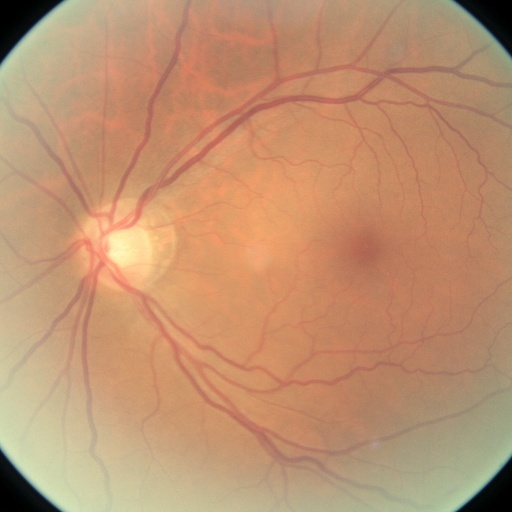

In [ ]:
last_conv_layer_name = "conv_pw_13"
img_size = (224, 224)
sample_img_path="/kaggle/input/ocular-disease/dataset/dataset/ARMD/0_1kIM_10_ARMD.png"/kaggle/input/ocular-disease/dataset/dataset/diabetic_retinopathy/1000_right.jpeg"
display(Image(sample_img_path))

heatmap: tf.Tensor(
[[[0.         0.         0.         0.         0.         0.18047088
   0.07632913]
  [0.         0.         0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         0.
   0.        ]
  [0.19670528 0.5576843  0.49756044 0.         0.         0.
   0.        ]
  [0.6146951  0.6092857  1.         0.         0.         0.
   0.        ]
  [0.60617465 0.18025854 0.56563264 0.0473519  0.         0.
   0.        ]
  [0.5129179  0.42905578 0.99310756 0.6678315  0.68168426 0.
   0.        ]]], shape=(1, 7, 7), dtype=float32)


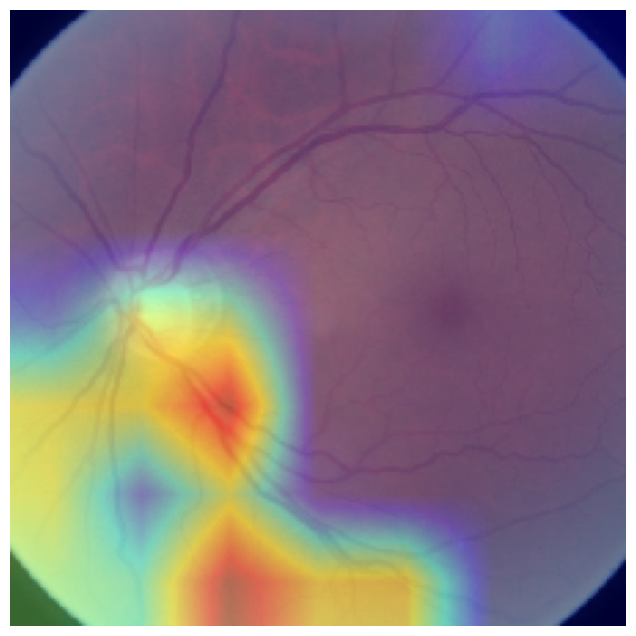

In [ ]:
def get_grad_cam(model, img, last_conv_layer_name):
    grad_model = tf.keras.Model(model.input, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        class_score = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    print("heatmap:", heatmap)
    return heatmap[0]


def display_grad_cam(img_path, model, last_conv_layer_name):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = get_grad_cam(model, img_array, last_conv_layer_name)

    heatmap = np.array(heatmap)

    original_img_size = img.size
    heatmap_resized = cv2.resize(heatmap, (original_img_size[0], original_img_size[1]))

    heatmap_resized = np.uint8(255 * heatmap_resized)

    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    img_rgb = np.uint8(255 * img_array[0])
    overlay = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


display_grad_cam(sample_img_path, model2, last_conv_layer_name)